## Exploratory Analysis

### Import Libraries

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, classification_report, make_scorer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from pdpbox import pdp, info_plots
from IPython.display import display
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
from tabulate import tabulate
import shap
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as plt_patches
from pandas.plotting import table
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

### Import Dataset

In [40]:
file_path = "https://raw.githubusercontent.com/sarahvastani/newrepo/refs/heads/main/FINAL%20DATASET%20-%20motusSurvivalPhenotypes.20241206.csv"
df = pd.read_csv(file_path)

df.head()

,reference,name_in_vcf,release_site,capture_site,release_year,tag_type,sex_binary,age_release,release_gps.n,release_gps.w,...,range_norm_distal,range_norm_carpal,range_norm_p7,range_norm_p8,range_norm_p9,range_norm_p10,range_norm_releaseDay,range_norm_fall_detectDay1,range_norm_fall_bearing1,range_norm_bodyCondition
0,AH17K18,AH17K18,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,NaN,NaN,NaN,NaN,0.666667,NaN,0.000000,NaN,NaN,0.849981
1,AH18K02,AH18K02,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,NaN,NaN,NaN,NaN,0.833333,NaN,0.043478,0.25,0.424781,0.674626
2,AH22K02,AH22K02,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,NaN,NaN,NaN,NaN,0.388889,NaN,0.217391,0.50,0.731704,0.347152
3,AH22K04,AH22K04_S154_L001,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,NaN,NaN,NaN,NaN,0.444444,NaN,0.217391,NaN,NaN,0.571480
4,AH22K09,AH22K09,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,NaN,NaN,NaN,NaN,0.444444,NaN,0.217391,0.55,0.836626,0.294291


### Correlations (raw dataset)

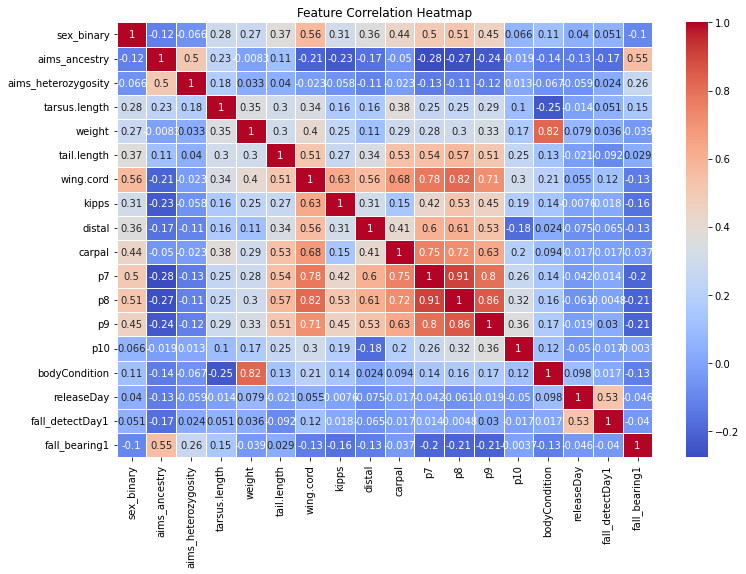

In [41]:
features = ['sex_binary','aims_ancestry','aims_heterozygosity','tarsus.length',
           'weight','tail.length','wing.cord','kipps','distal','carpal','p7','p8','p9',
           'p10','bodyCondition','releaseDay','fall_detectDay1','fall_bearing1']

df_subset = df[features]

correlations = df_subset.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Nulls after removing correlated features (raw dataset)

In [42]:
features = ['sex_binary','aims_ancestry','aims_heterozygosity','tarsus.length',
           'tail.length','wing.cord','kipps','distal','p10',
           'bodyCondition','releaseDay','fall_detectDay1','fall_bearing1']

df_subset = df[features]

missing_percentage = df_subset.isna().mean() * 100
missing_df = pd.DataFrame({
    'Column': features,
    'Missing Percentage': missing_percentage
})

missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False)
missing_df

,Column,Missing Percentage
fall_detectDay1,fall_detectDay1,27.766180
fall_bearing1,fall_bearing1,27.766180
distal,distal,13.152401
p10,p10,12.734864
bodyCondition,bodyCondition,2.922756
tarsus.length,tarsus.length,1.252610
kipps,kipps,1.043841
tail.length,tail.length,0.626305
wing.cord,wing.cord,0.417537
sex_binary,sex_binary,0.000000


### Distribution of the features after removing features with high nulls (raw dataset)

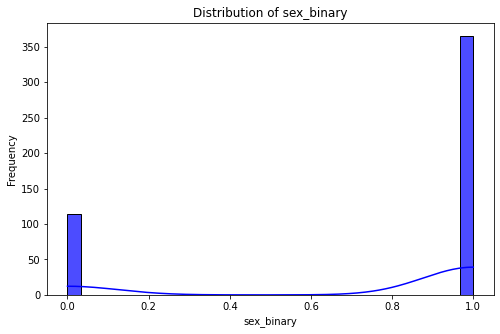

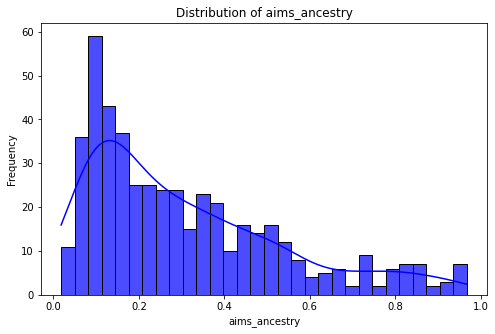

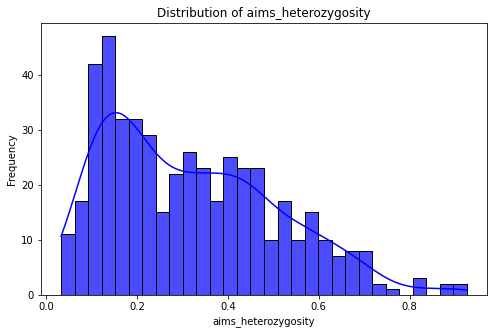

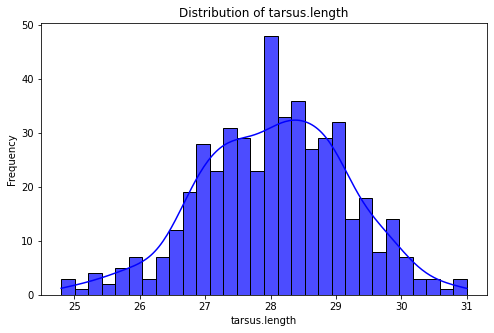

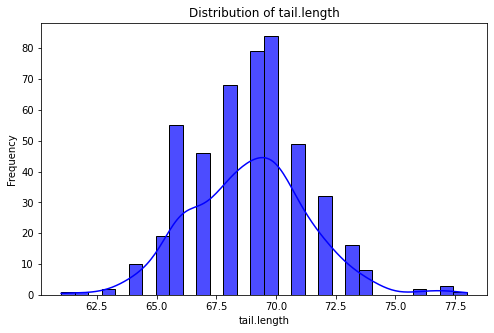

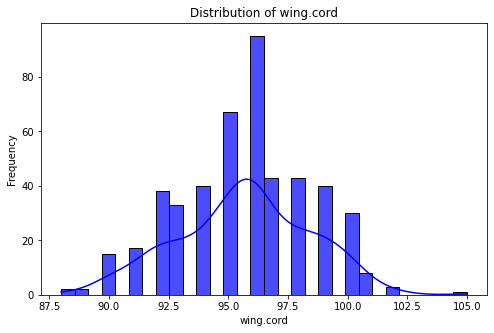

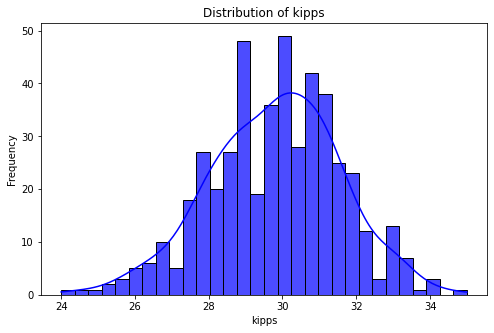

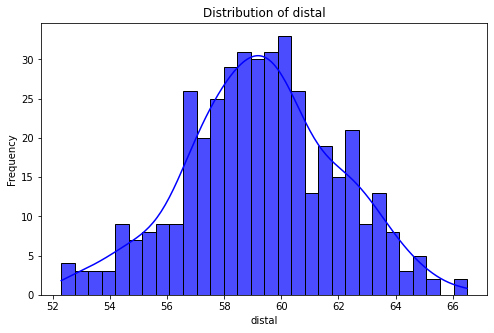

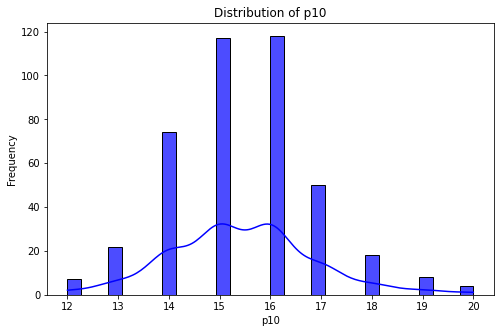

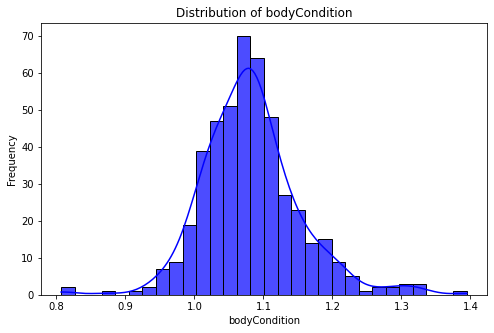

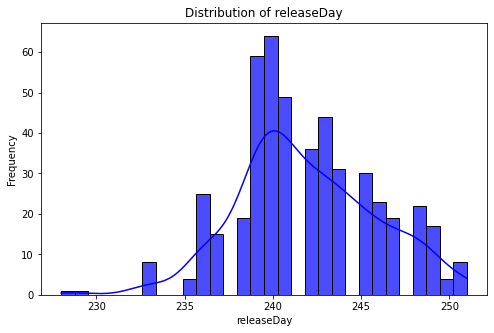

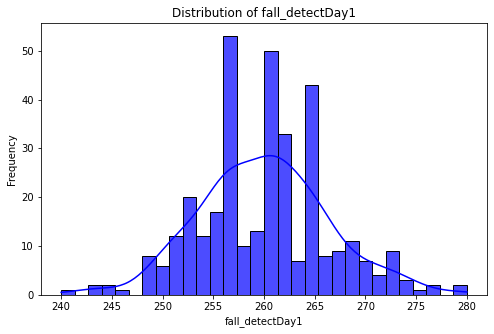

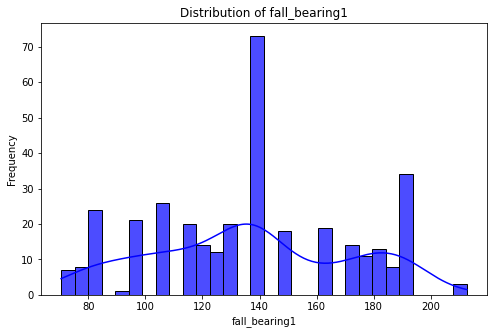

In [43]:
for feature in features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], kde=True, bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

### Ratio of survived to died (same column for both datasets)

In [44]:
binary_columns = ['t5_spring40']
percentages = {}

for column in binary_columns:
    total_count = df[column].count()  
    count_0 = (df[column] == 0).sum()
    count_1 = (df[column] == 1).sum()

    percent_0 = (count_0 / total_count) * 100
    percent_1 = (count_1 / total_count) * 100

    percentages[column] = {
        'Percentage of 0': percent_0,
        'Percentage of 1': percent_1
    }

percentages_df = pd.DataFrame(percentages).T
print(percentages_df)

             Percentage of 0  Percentage of 1
t5_spring40        78.496868        21.503132


### Correlations (range norm dataset)

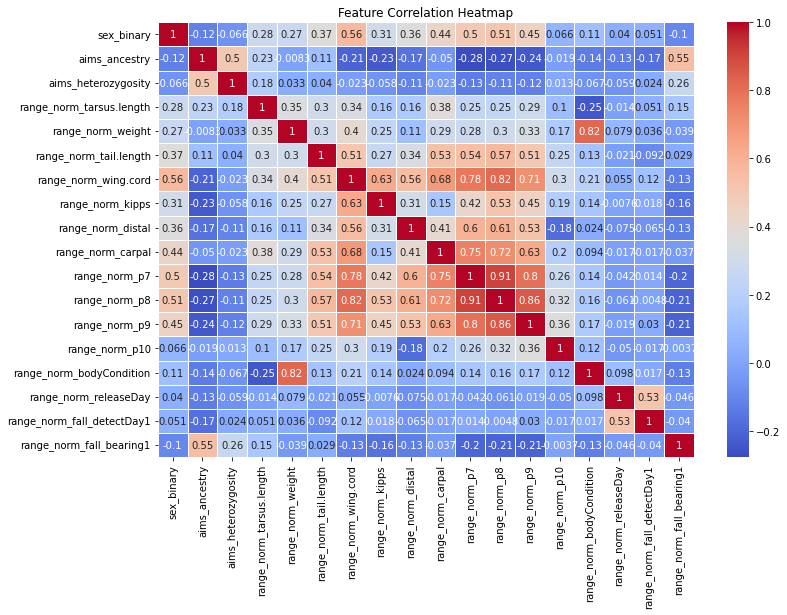

In [45]:
features = ['sex_binary','aims_ancestry','aims_heterozygosity',
            'range_norm_tarsus.length',
           'range_norm_weight','range_norm_tail.length','range_norm_wing.cord',
            'range_norm_kipps','range_norm_distal','range_norm_carpal',
            'range_norm_p7','range_norm_p8','range_norm_p9',
           'range_norm_p10','range_norm_bodyCondition','range_norm_releaseDay',
            'range_norm_fall_detectDay1','range_norm_fall_bearing1']

df_subset = df[features]

correlations = df_subset.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Nulls after removing correlated features (range norm dataset)

In [47]:
features = ['sex_binary','aims_ancestry','aims_heterozygosity',
            'range_norm_tarsus.length',
           'range_norm_tail.length','range_norm_wing.cord',
            'range_norm_kipps','range_norm_distal',
           'range_norm_p10','range_norm_bodyCondition','range_norm_releaseDay',
            'range_norm_fall_detectDay1','range_norm_fall_bearing1']

df_subset = df[features]

missing_percentage = df_subset.isna().mean() * 100
missing_df = pd.DataFrame({
    'Column': features,
    'Missing Percentage': missing_percentage
})

missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False)
missing_df

,Column,Missing Percentage
range_norm_fall_detectDay1,range_norm_fall_detectDay1,27.766180
range_norm_fall_bearing1,range_norm_fall_bearing1,27.766180
range_norm_distal,range_norm_distal,13.152401
range_norm_p10,range_norm_p10,12.734864
range_norm_bodyCondition,range_norm_bodyCondition,2.922756
range_norm_tarsus.length,range_norm_tarsus.length,1.252610
range_norm_kipps,range_norm_kipps,1.043841
range_norm_tail.length,range_norm_tail.length,0.626305
range_norm_wing.cord,range_norm_wing.cord,0.417537
sex_binary,sex_binary,0.000000


### Distribution of the features after removing features with high nulls (range norm dataset)

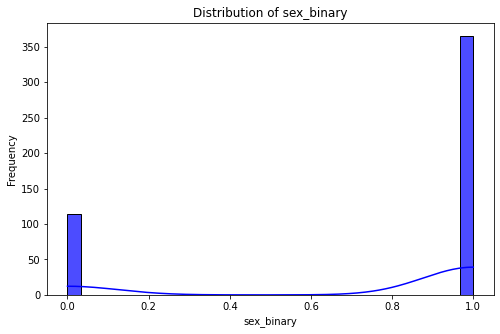

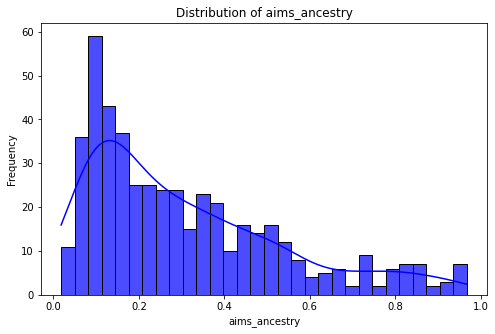

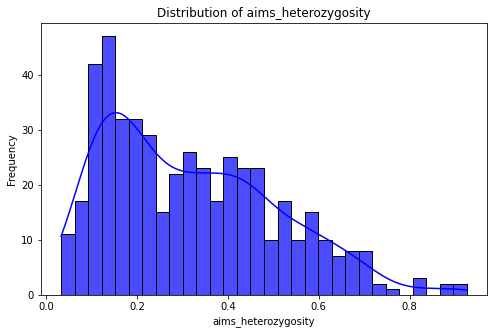

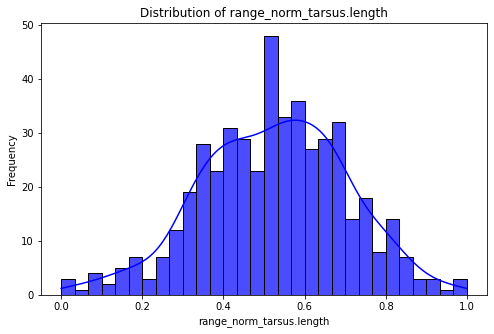

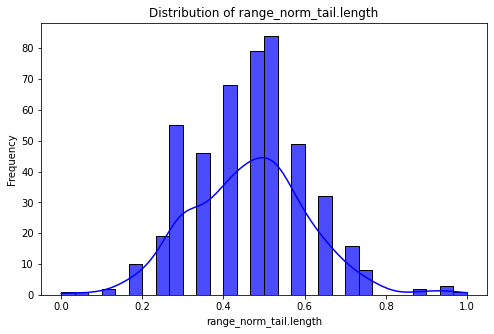

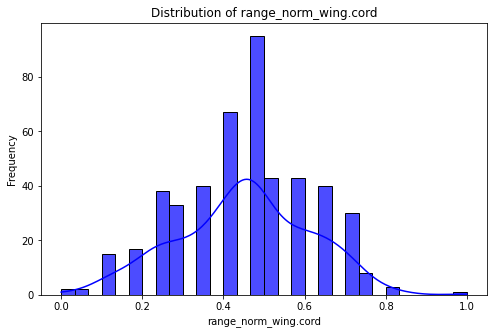

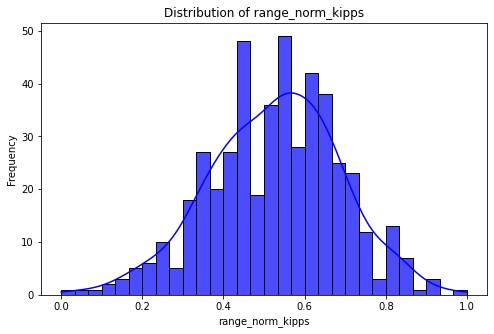

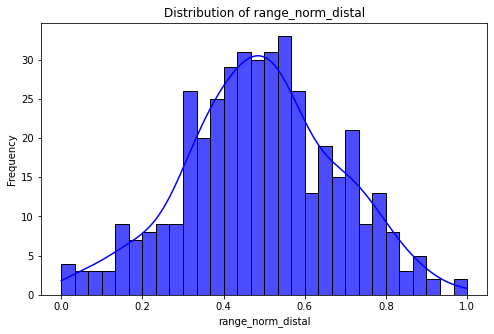

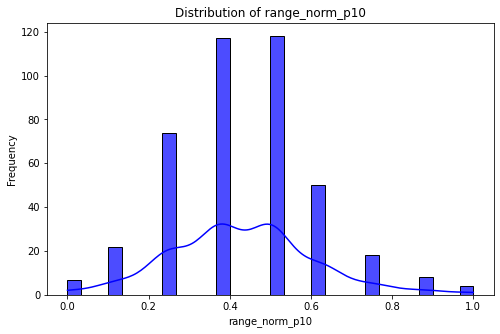

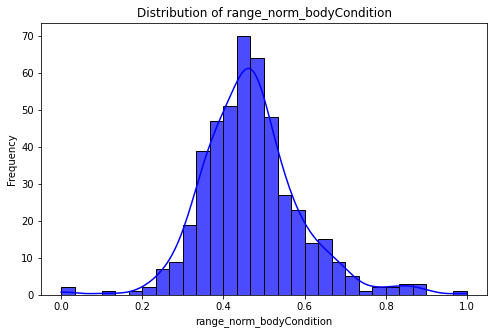

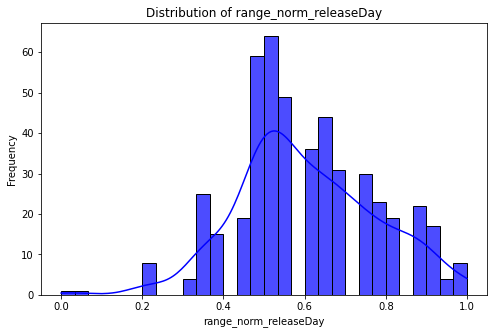

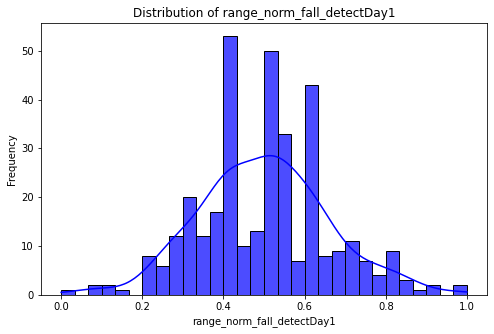

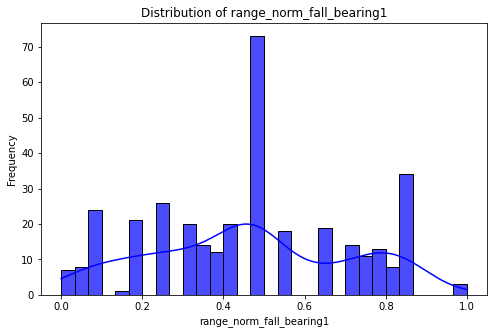

In [48]:
for feature in features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], kde=True, bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()